<a href="https://colab.research.google.com/github/m-wessler/nbm-verification/blob/main/NBM_4_x_PoWT_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# @title Imports etc
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# INSTALL AND IMPORTS                                                         #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

!pip install boto3
!pip install pygrib
!pip install swifter
!pip install xarray cfgrib pygrib

import boto3
from botocore import UNSIGNED
from botocore.client import Config
from datetime import datetime, timedelta

import os
import cfgrib
import pygrib
import numpy as np
import pandas as pd
import xarray as xr

from concurrent.futures import ThreadPoolExecutor, as_completed

import gc
import os
import time
import json
import boto3
import pygrib
import swifter
import zipfile
import requests
import itertools

import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

from glob import glob
from typing import List, Optional
from pydantic import BaseModel, Field

from functools import partial
from google.colab import files
from matplotlib.gridspec import GridSpec
from datetime import datetime, timedelta
from collections import defaultdict, OrderedDict

from multiprocessing import Pool, cpu_count
from multiprocessing import set_start_method, get_context

from sklearn.metrics import RocCurveDisplay
from sklearn.calibration import CalibrationDisplay
from sklearn.metrics import (brier_score_loss, f1_score, log_loss,
                                precision_score, recall_score, roc_auc_score)

import warnings
warnings.filterwarnings('ignore')

idx = pd.IndexSlice

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 95.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.8/84.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.6/18.6 MB 96.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 13.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for swifter: filename=swifter-1.4.0-py3-none-any.whl size=16505 sha256=2f9d7b2c0f493896e2575cd4aa45c203b0a9b21cb458227abeb93e811ceefd95
  Stored in directory: /root/.cache/pip/wheels/ef/7f/bd/9bed48f078f3ee1fa75e0b29b6e0335ce1cb03a38d3443b3a3
Successfully built swifter
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 67.0 MB/s eta 0:00:00


In [41]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# COLAB MARKDOWN AND USER CONFIGS                                             #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# @markdown <FONT SIZE=5>**1. Please Provide Your Synoptic API Token...**
user_token = "a2386b75ecbc4c2784db1270695dde73" # @param {type:"string"}

# @markdown <FONT SIZE=5>**2. Select Start and End Dates**
start_date = "2023-11-01" # @param {type:"date"}
end_date = "2024-04-30" # @param {type:"date"}

## @markdown <FONT SIZE=5>**3. For Which Element?**
##"qpf24" # @param ["maxt", "mint", "qpf24", "qpf12", "qpf06"]
element = "powt"

# Split element/interval
# interval_selection = int(element[-2:]) if "qpf" in element else False
# element = element[:3] if "qpf" in element else element

#6/12/24/48/72, if element==temp then False
# interval_selection = "24" #@param ["24", "12", "6"]
# interval_selection = interval_selection if element == "qpf" else False

#temperature_threshold = -60 #@param {type:"slider", min:-60, max:140, step:10}
#qpf_threshold = 0.31 #@param {type:"slider", min:0.01, max:5.00, step:0.01}

#if element in ["maxt","mint"]:
#    threshold = temperature_threshold
#elif element in ["qpf"]:
#    threshold = qpf_threshold

# @markdown <FONT SIZE=5>**3. Tolerance +/- top of the hour obs (minutes)?**
tolerance = 30 #@param {type:"slider", min:0, max:90, step:15}
tolerance = pd.Timedelta(f"{tolerance}min")

## @markdown <FONT SIZE=5>**3. For Which Init Hour?**
# init_hour_selection = "12" #@param ['00', '06', '12', '18']
# init_hour_selection = int(init_hour_selection)

# @markdown <FONT SIZE=5>**4. For Which Lead Time (in days)?**
lead_days_selection = 1 #@param {type:"slider", min:1, max:8, step:1}

# @markdown <FONT SIZE=5>**5. For Which Region?**
region_selection = "CWA" #@param ["WR", "SR", "CR", "ER", "CONUS", "CWA", "RFC"]

#@markdown If CWA/RFC selected, which one? (i.e. "SLC" for Salt Lake City, "CBRFC" for Colorado Basin)
cwa_selection = 'SEW,PQR,MFR,PDT,OTX' #@param {type:"string"}

## @markdown For Which Networks?
#network_selection = 'NWS+RAWS+HADS'#@param ["NWS+RAWS", "NWS+RAWS+HADS", "NWS", "RAWS", "HADS", "SNOTEL", "ALL"]
network_selection = 'NWS'

# @markdown Check box to display plots inline (default unchecked for download)
display_inline = True #@param {type:"boolean"}

In [6]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# GLOBAL VARIABLES AND GENERAL CONFIG                                         #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Multiprocess settings
process_pool_size = 20 #cpu_count()*16
print(f'Process Pool Size: {process_pool_size}')

# Backend APIs
metadata_api = "https://api.synopticdata.com/v2/stations/metadata?"
qc_api = "https://api.synopticdata.com/v2/stations/qcsegments?"

# Data Query APIs
timeseries_api = "https://api.synopticdata.com/v2/stations/timeseries?"
statistics_api = "https://api.synopticlabs.org/v2/stations/statistics?"
precipitation_api = "https://api.synopticdata.com/v2/stations/precipitation?"

# Assign API to element name
synoptic_apis = {
    'qpf':precipitation_api,
    'maxt':statistics_api,
    'mint':statistics_api,
    'powt':timeseries_api}

synoptic_networks = {"NWS+RAWS+HADS":"1,2,106",
                     "NWS+RAWS":"1,2",
                     "NWS":"1",
                     "RAWS": "2",
                     "HADS": "106",
                     "SNOTEL":"25",
                     "ALL":None}
                    #  "CUSTOM": "&network="+network_input,
                    #  "LIST": "&stid="+network_input}

# Assign synoptic variable to element name
synoptic_vars = {'powt':'weather_condition,weather_summary,' \
        'weather_cond_code_synop,past_weather_code,weather_cond_code,air_temp'}

synoptic_vars_out = {
    'powt':''}

# Assign stat type to element name
stat_type = {
    'powt':None}

ob_hours = {
    'powt':['0000']}

# Where to place the grib files (subdirs can be added in local) (not used)
output_dir = './' #/nas/stid/data/nbm-verification/temp/'

# Convert user input to datetime objects
start_date, end_date = [datetime.strptime(date+' 0000', '%Y-%m-%d %H%M')
    for date in [start_date, end_date]]

# Build synoptic arg dict
synoptic_api_args = {
    'ob_stat':stat_type[element],
    'api':synoptic_apis[element],
    'element':element,
    'interval':24, #24h to poll daily powt data
    #interval_selection if element == 'qpf' else False,
    'region':region_selection,
    'network_query':synoptic_networks[network_selection], # add config feature later
    'vars_query':None if element == 'qpf'
        else f'{synoptic_vars[element]}',}

Process Pool Size: 20


In [7]:
class PeriodOfRecord(BaseModel):
    start: str
    end: str

class Providers(BaseModel):
    name: str
    url: str

class Units(BaseModel):
    position: str
    elevation: str

class SensorVariables(BaseModel):
    air_temp: dict = Field(default_factory=dict)
    weather_summary: dict = Field(default_factory=dict)
    weather_condition: dict = Field(default_factory=dict)
    weather_cond_code: dict = Field(default_factory=dict)
    past_weather_code: dict = Field(default_factory=dict)
    weather_cond_code_synop: dict = Field(default_factory=dict)

class Observations(BaseModel):
    date_time: List[str]

    air_temp_set_1: List[Optional[float]] = Field(default_factory=list)
    air_temp_set_1d: List[Optional[float]] = Field(default_factory=list)

    weather_summary_set_1: List[Optional[str]] = Field(default_factory=list)
    weather_summary_set_1d: List[Optional[str]] = Field(default_factory=list)

    weather_condition_set_1: List[Optional[str]] = Field(default_factory=list)
    weather_condition_set_1d: List[Optional[str]] = Field(default_factory=list)

    weather_cond_code_set_1: List[Optional[float]] = Field(default_factory=list)
    weather_cond_code_set_1d: List[Optional[float]] = Field(default_factory=list)

    weather_cond_code_synop_set_1: List[Optional[object]] = Field(default_factory=list)
    weather_cond_code_synop_set_1d: List[Optional[object]] = Field(default_factory=list)

    past_weather_code_set_1: List[Optional[object]] = Field(default_factory=list)
    past_weather_code_set_1d: List[Optional[object]] = Field(default_factory=list)

    class Config:
        allow_population_by_field_name = True
        arbitrary_types_allowed = True
        strict = False

class Station(BaseModel):
    ID: str
    STID: str
    NAME: str
    ELEVATION: float
    LATITUDE: float
    LONGITUDE: float
    STATUS: str
    MNET_ID: str
    STATE: str
    TIMEZONE: str
    ELEV_DEM: object
    # NWSZONE: str
    # NWSFIREZONE: str
    # GACC: str
    SHORTNAME: str
    # SGID: str
    COUNTY: str
    # COUNTRY: str
    # WIMS_ID: str
    CWA: str
    PERIOD_OF_RECORD: PeriodOfRecord
    # PROVIDERS: Providers
    UNITS: Units
    SENSOR_VARIABLES: SensorVariables
    OBSERVATIONS: Observations
    QC_FLAGGED: bool
    RESTRICTED: bool

class Data(BaseModel):
    STATION: List[Station]

    def to_dataframe(self) -> pd.DataFrame:
        records = []

        for station in self.STATION:
            for i, date_time in enumerate(station.OBSERVATIONS.date_time):
                record = {
                    'stid': station.STID,
                    'latitude': station.LATITUDE,
                    'longitude': station.LONGITUDE,
                    'elevation': station.ELEVATION,
                    'state': station.STATE,
                    'cwa': station.CWA,
                    'timestamp':date_time,

                    'air_temp_set_1': station.OBSERVATIONS.air_temp_set_1[i] if len(station.OBSERVATIONS.air_temp_set_1) > i else None,
                    'weather_summary_set_1': station.OBSERVATIONS.weather_summary_set_1[i] if len(station.OBSERVATIONS.weather_summary_set_1) > i else None,
                    'weather_condition_set_1': station.OBSERVATIONS.weather_condition_set_1[i] if len(station.OBSERVATIONS.weather_condition_set_1) > i else None,
                    'weather_cond_code_set_1': station.OBSERVATIONS.weather_cond_code_set_1[i] if len(station.OBSERVATIONS.weather_cond_code_set_1) > i else None,
                    'past_weather_code_set_1': station.OBSERVATIONS.past_weather_code_set_1[i] if len(station.OBSERVATIONS.past_weather_code_set_1) > i else None,
                    'weather_cond_code_synop_set_1': station.OBSERVATIONS.weather_cond_code_synop_set_1[i] if len(station.OBSERVATIONS.weather_cond_code_synop_set_1) > i else None,

                    'air_temp_set_1d': station.OBSERVATIONS.air_temp_set_1d[i] if len(station.OBSERVATIONS.air_temp_set_1d) > i else None,
                    'weather_summary_set_1d': station.OBSERVATIONS.weather_summary_set_1d[i] if len(station.OBSERVATIONS.weather_summary_set_1d) > i else None,
                    'weather_condition_set_1d': station.OBSERVATIONS.weather_condition_set_1d[i] if len(station.OBSERVATIONS.weather_condition_set_1d) > i else None,
                    'weather_cond_code_set_1d': station.OBSERVATIONS.weather_cond_code_set_1d[i] if len(station.OBSERVATIONS.weather_cond_code_set_1d) > i else None,
                    'past_weather_code_set_1d': station.OBSERVATIONS.past_weather_code_set_1d[i] if len(station.OBSERVATIONS.past_weather_code_set_1d) > i else None,
                    'weather_cond_code_synop_set_1d': station.OBSERVATIONS.weather_cond_code_synop_set_1d[i] if len(station.OBSERVATIONS.weather_cond_code_synop_set_1d) > i else None
                }
                records.append(record)

        df = pd.DataFrame(records)
        return df

In [8]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# FUNCTIONS AND METHODS (GENERAL)                                             #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

def mkdir_p(check_dir):
    from pathlib import Path
    check_dir = output_dir + check_dir
    Path(check_dir).mkdir(parents=True, exist_ok=True)
    return check_dir

In [9]:
def cwa_list(input_region):

    input_region = input_region.upper()

    region_dict ={
        "WR":["BYZ", "BOI", "LKN", "EKA", "FGZ", "GGW", "TFX", "VEF", "LOX", "MFR",
            "MSO", "PDT", "PSR", "PIH", "PQR", "REV", "STO", "SLC", "SGX", "MTR",
            "HNX", "SEW", "OTX", "TWC"],

        "CR":["ABR", "BIS", "CYS", "LOT", "DVN", "BOU", "DMX", "DTX", "DDC", "DLH",
            "FGF", "GLD", "GJT", "GRR", "GRB", "GID", "IND", "JKL", "EAX", "ARX",
            "ILX", "LMK", "MQT", "MKX", "MPX", "LBF", "APX", "IWX", "OAX", "PAH",
            "PUB", "UNR", "RIW", "FSD", "SGF", "LSX", "TOP", "ICT"],

        "ER":["ALY", "LWX", "BGM", "BOX", "BUF", "BTV", "CAR", "CTP", "RLX", "CHS",
            "ILN", "CLE", "CAE", "GSP", "MHX", "OKX", "PHI", "PBZ", "GYX", "RAH",
            "RNK", "AKQ", "ILM"],

        "SR":["ABQ", "AMA", "FFC", "EWX", "BMX", "BRO", "CRP", "EPZ", "FWD", "HGX",
            "HUN", "JAN", "JAX", "KEY", "MRX", "LCH", "LZK", "LUB", "MLB", "MEG",
            "MAF", "MFL", "MOB", "MRX", "OHX", "LIX", "OUN", "SJT", "SHV", "TAE",
            "TBW", "TSA"]}

    if input_region == "CONUS":
        return np.hstack([region_dict[region] for region in region_dict.keys()])
    else:
        return region_dict[input_region]

def cwa_list_rfc(input_rfc):

    metadata_api = 'https://api.synopticdata.com/v2/stations/metadata?'

    network_query = (f"&network={synoptic_networks[network_selection]}"
                    if synoptic_networks[network_selection] is not None else '')

    # Assemble the API query
    api_query = (f"{metadata_api}&token={user_token}" + network_query +
                f"&complete=1&sensorvars=1,obrange=20230118") #hardcoded for NBM4.1+

    # Print the API query to output
    # print(api_query)

    # Get the data from the API
    response = requests.get(api_query)
    metadata = pd.DataFrame(response.json()['STATION'])

    # Remove NaNs and index by network, station ID
    metadata = metadata[metadata['MNET_SHORTNAME'].notna()]
    metadata = metadata.set_index(['MNET_SHORTNAME', 'STID'])

    metadata['LATITUDE'] = metadata['LATITUDE'].astype(float)
    metadata['LONGITUDE'] = metadata['LONGITUDE'].astype(float)
    metadata['ELEVATION'] = metadata['ELEVATION'].astype(float)

    metadata = metadata[metadata['LATITUDE'] >= 31]
    metadata = metadata[metadata['LONGITUDE'] <= -103.00]
    metadata = metadata[metadata['STATUS'] == 'ACTIVE']

    geometry = gpd.points_from_xy(metadata.LONGITUDE, metadata.LATITUDE)
    metadata = gpd.GeoDataFrame(metadata, geometry=geometry)

    req = requests.get(
        'https://www.weather.gov/source/gis/Shapefiles/Misc/rf05mr24.zip',

    allow_redirects=True)
    open('rf05mr24.zip', 'wb').write(req.content)

    with zipfile.ZipFile('rf05mr24.zip', 'r') as zip_ref:
        zip_ref.extractall()

    rfc_shp = gpd.read_file('rf05mr24.shp').set_index('BASIN_ID')

    metadata = metadata[metadata.geometry.within(rfc_shp.geometry.loc[input_rfc])]

    rfc_site_list = metadata.index.get_level_values(1).unique()
    rfc_cwa_list = metadata['CWA'].unique()

    return metadata

In [10]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# FUNCTIONS AND METHODS (SYNOPTIC API)                                        #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

def fetch_obs_from_API(valid_datetime, cwa='', output_type='json',
                       use_saved=True, **req):

    start_adjusted = (datetime.strptime(valid_datetime, '%Y%m%d%H%M')
                        - timedelta(hours=req["interval"]))

    end_adjusted = datetime.strptime(valid_datetime, '%Y%m%d%H%M')

    valid = True
    cwa_filename = (region_selection if region_selection != 'CWA'
                    else cwa_selection)

    element_label = req['element'] if req['element'] != 'qpf' else \
                        'qpe' + f'{req["interval"]:02d}'


    output_file = mkdir_p(f'obs_{output_type}/') +\
        f'obs.{element_label}.{req["ob_stat"]}' +\
        f'.{valid_datetime}.{cwa_filename}.{output_type}'

    if os.path.isfile(output_file) & use_saved:
        print(f'Output file exists for:{iter_item}')

        with open(output_file, 'r') as f:
            data = Data.model_validate_json(f.read())

            # Convert to DataFrame
            df = data.to_dataframe()
            df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)

            return df

    else:
        json_file = mkdir_p('obs_json/') +\
            f'obs.{element_label}.{req["ob_stat"]}' +\
            f'.{valid_datetime}.{cwa_filename}.json'

        # if os.path.isfile(json_file) & use_saved:
        #     # print(f'Polling archived JSON for: {iter_item}')

        #     with open(json_file, 'rb+') as rfp:
        #         response_dataframe = pd.json_normalize(json.load(rfp)['STATION'])

        # else:
        api_query_args = {
            'api_token':f'&token={user_token}',
            'station_query':f'&cwa={cwa}',
            'network_query':(f'&network={req["network_query"]}'
                                if req["network_query"] is not None else ''),

            'start_date_query':f'&start={start_adjusted.strftime("%Y%m%d%H%M")}',
            'end_date_query':f'&end={end_adjusted.strftime("%Y%m%d%H%M")}',

            'vars_query':(f'&pmode=intervals&interval={req["interval"]}'
                            if req["element"] == 'qpf'
                            else f'&vars={req["vars_query"]}'),
            'stats_query':f'&type={req["ob_stat"]}',
            'timezone_query':'&obtimezone=utc',
            'api_extras':'&units=temp|f&complete=True'}
                #'&fields=name,status,latitude,longitude,elevation'

        api_query = req['api'] + ''.join(
            [api_query_args[k] for k in api_query_args.keys()])

        print(f'Polling API for: {iter_item}\n{api_query}')

        status_code, response_count = None, 0
        while (status_code != 200) & (response_count <= 10):
            print(f'{iter_item}, HTTP:{status_code}, #:{response_count}')

            # Don't sleep first try, sleep increasing amount for each retry
            time.sleep(2*response_count)

            response = requests.get(api_query)
            # response.raise_for_status()

            status_code = response.status_code
            response_count += 1

        try:
            response_dataframe = pd.json_normalize(
                response.json()['STATION'])
        except:
            valid = False
        else:
            with open(json_file, 'wb+') as wfp:
                wfp.write(response.content)

    if valid:
        # Example usage
        # with open('sample.json', 'r') as f:
        data = Data.model_validate_json(response.content)

        # Convert to DataFrame
        df = data.to_dataframe()
        df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize(None)

        return df

    else:
        return None

In [11]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# INPUT-BASED GLOBAL VARIABLES AND CONFIG                                     #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #

# Build an iterable date list from range
iter_date = start_date
valid_date_iterable = []
valid_datetime_iterable = []
forecast_datetime_iterable = []

while iter_date <= end_date:

    valid_date_iterable.append(iter_date.strftime('%Y%m%d'))

    for hour_range in ob_hours[element]:
        end_hour = f'{int(hour_range[-1]):02d}'

        valid_datetime_iterable.append(iter_date.strftime('%Y%m%d') + end_hour)

        forecast_datetime_iterable.append(
                (iter_date-timedelta(days=lead_days_selection)
            ).strftime('%Y%m%d') + end_hour)

    iter_date += timedelta(days=1)

# Assign the fixed kwargs to the function
if region_selection == 'CWA':
    cwa_query = cwa_selection
elif region_selection == 'RFC':
    rfc_metadata = cwa_list_rfc(cwa_selection)
    cwa_query = ','.join([str(cwa) for cwa in rfc_metadata['CWA'].unique()
                if cwa is not None])
else:
    cwa_query = ','.join(cwa_list(region_selection))

In [12]:
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
# DATA ACQUISITION                                                            #
# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # # #
multiprocess_function = partial(fetch_obs_from_API,
                                cwa=cwa_query,
                                **synoptic_api_args)

df_list = []
# Multithreaded requests currently not supported by the Synoptic API
for iter_item in valid_datetime_iterable:
    df_list.append(multiprocess_function(iter_item))

df = pd.concat(df_list).set_index(['timestamp', 'stid']).sort_index().drop_duplicates()

# Combine similarly named columns
for col in df.columns:
    if col.endswith('_1'):
        new_col_name = col[:-6]  # Remove the last two characters (_1)
        df[new_col_name] = df[col].combine_first(df[col + 'd'])  # Keep non-NaN values

# Drop the original _1 and _1d columns if needed
obs = df.drop(columns=[col for col in df.columns if col.endswith(('_1', '_1d'))])

# Display the resulting DataFrame
obs

Polling API for: 2023110100
https://api.synopticdata.com/v2/stations/timeseries?&token=a2386b75ecbc4c2784db1270695dde73&cwa=SEW,PQR,MFR,PDT,OTX&network=1&start=202310310000&end=202311010000&vars=weather_condition,weather_summary,weather_cond_code_synop,past_weather_code,weather_cond_code,air_temp&type=None&obtimezone=utc&units=temp|f&complete=True
2023110100, HTTP:None, #:0
Polling API for: 2023110200
https://api.synopticdata.com/v2/stations/timeseries?&token=a2386b75ecbc4c2784db1270695dde73&cwa=SEW,PQR,MFR,PDT,OTX&network=1&start=202311010000&end=202311020000&vars=weather_condition,weather_summary,weather_cond_code_synop,past_weather_code,weather_cond_code,air_temp&type=None&obtimezone=utc&units=temp|f&complete=True
2023110200, HTTP:None, #:0
Polling API for: 2023110300
https://api.synopticdata.com/v2/stations/timeseries?&token=a2386b75ecbc4c2784db1270695dde73&cwa=SEW,PQR,MFR,PDT,OTX&network=1&start=202311020000&end=202311030000&vars=weather_condition,weather_summary,weather_cond_code

latitude  longitude  elevation state  cwa air_temp  \
timestamp           stid                                                       
2023-10-31 00:00:00 KAAT  41.48362 -120.56150     4383.0    CA  MFR     60.8   
                    KALW  46.09462 -118.28580     1168.0    WA  PDT     44.6   
                    KAST  46.15694 -123.88250       10.0    OR  PQR     60.8   
                    KAWO  48.15850 -122.15909      125.0    WA  SEW     51.8   
                    KBFI  47.54548 -122.31470       20.0    WA  SEW     53.6   
...                            ...        ...        ...   ...  ...      ...   
2024-04-29 23:00:00 KMWH  47.19299 -119.31451     1168.0    WA  OTX     50.0   
2024-04-29 23:35:00 K1S5  46.32710 -119.97040      768.0    WA  PDT    51.44   
                    KELN  47.03377 -120.53132     1745.0    WA  PDT     51.8   
2024-04-29 23:53:00 KELN  47.03377 -120.53132     1745.0    WA  PDT    51.08   
2024-04-29 23:55:00 KGRF  47.11667 -122.55000      302.0    WA  SEW    49.28   

                         weather_summary weather_condition weather_cond_code  \
timestamp           stid                                                       
2023-10-31 00:00:00 KAAT           clear              None              None   
                    KALW           clear              None              None   
                    KAST           clear              None              None   
                    KAWO           clear              None              None   
                    KBFI           clear              None              None   
...                                  ...               ...               ...   
2024-04-29 23:00:00 KMWH            rain              rain               1.0   
2024-04-29 23:35:00 K1S5   light drizzle     light drizzle              17.0   
                    KELN            None              None              None   
2024-04-29 23:53:00 KELN            None              None              None   
2024-04-29 23:55:00 KGRF            rain              rain               1.0   

                         past_weather_code weather_cond_code_synop  
timestamp           stid                                            
2023-10-31 00:00:00 KAAT              None                    None  
                    KALW              None                    None  
                    KAST              None                    None  
                    KAWO              None                    None  
                    KBFI              None                    None  
...                                    ...                     ...  
2024-04-29 23:00:00 KMWH              None                    None  
2024-04-29 23:35:00 K1S5              None                    None  
                    KELN              None                    None  
2024-04-29 23:53:00 KELN              None                    None  
2024-04-29 23:55:00 KGRF              None                    None  

[60498 rows x 11 columns]

In [13]:
obs.rename(columns={'air_temp':'observed_air_temp'}, inplace=True)
obs['weather_condition'] = obs['weather_condition'].astype(str)
obs

latitude  longitude  elevation state  cwa  \
timestamp           stid                                              
2023-10-31 00:00:00 KAAT  41.48362 -120.56150     4383.0    CA  MFR   
                    KALW  46.09462 -118.28580     1168.0    WA  PDT   
                    KAST  46.15694 -123.88250       10.0    OR  PQR   
                    KAWO  48.15850 -122.15909      125.0    WA  SEW   
                    KBFI  47.54548 -122.31470       20.0    WA  SEW   
...                            ...        ...        ...   ...  ...   
2024-04-29 23:00:00 KMWH  47.19299 -119.31451     1168.0    WA  OTX   
2024-04-29 23:35:00 K1S5  46.32710 -119.97040      768.0    WA  PDT   
                    KELN  47.03377 -120.53132     1745.0    WA  PDT   
2024-04-29 23:53:00 KELN  47.03377 -120.53132     1745.0    WA  PDT   
2024-04-29 23:55:00 KGRF  47.11667 -122.55000      302.0    WA  SEW   

                         observed_air_temp weather_summary weather_condition  \
timestamp           stid                                                       
2023-10-31 00:00:00 KAAT              60.8           clear              None   
                    KALW              44.6           clear              None   
                    KAST              60.8           clear              None   
                    KAWO              51.8           clear              None   
                    KBFI              53.6           clear              None   
...                                    ...             ...               ...   
2024-04-29 23:00:00 KMWH              50.0            rain              rain   
2024-04-29 23:35:00 K1S5             51.44   light drizzle     light drizzle   
                    KELN              51.8            None              None   
2024-04-29 23:53:00 KELN             51.08            None              None   
2024-04-29 23:55:00 KGRF             49.28            rain              rain   

                         weather_cond_code past_weather_code  \
timestamp           stid                                       
2023-10-31 00:00:00 KAAT              None              None   
                    KALW              None              None   
                    KAST              None              None   
                    KAWO              None              None   
                    KBFI              None              None   
...                                    ...               ...   
2024-04-29 23:00:00 KMWH               1.0              None   
2024-04-29 23:35:00 K1S5              17.0              None   
                    KELN              None              None   
2024-04-29 23:53:00 KELN              None              None   
2024-04-29 23:55:00 KGRF               1.0              None   

                         weather_cond_code_synop  
timestamp           stid                          
2023-10-31 00:00:00 KAAT                    None  
                    KALW                    None  
                    KAST                    None  
                    KAWO                    None  
                    KBFI                    None  
...                                          ...  
2024-04-29 23:00:00 KMWH                    None  
2024-04-29 23:35:00 K1S5                    None  
                    KELN                    None  
2024-04-29 23:53:00 KELN                    None  
2024-04-29 23:55:00 KGRF                    None  

[60498 rows x 11 columns]

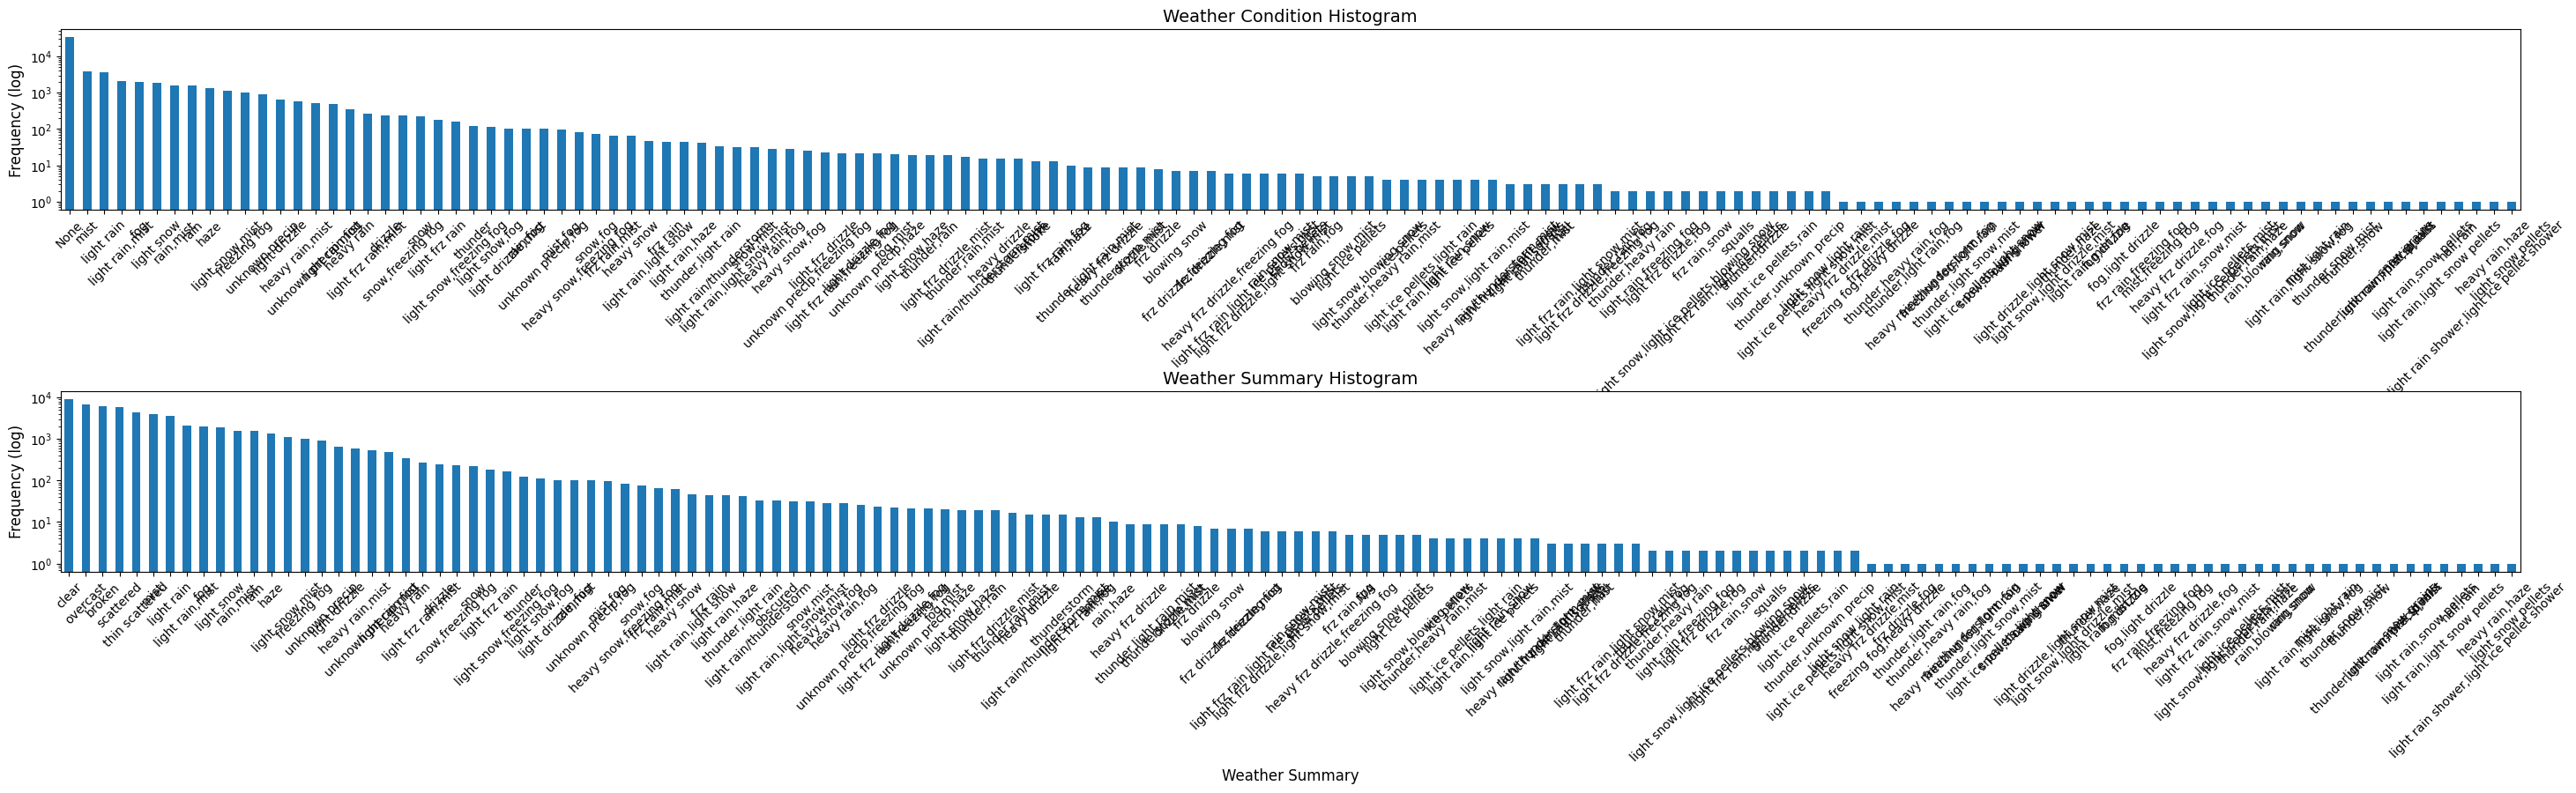

In [15]:
fig = plt.figure(figsize=(36, 8))
gs = GridSpec(2, 1, figure=fig, hspace=1)

ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

obs['weather_condition'].value_counts().plot(kind='bar', ax=ax0,logy=True)
ax0.set_title('Weather Condition Histogram', fontsize=14)
ax0.set_xlabel('Weather Condition', fontsize=12)
ax0.set_ylabel('Frequency (log)', fontsize=12)
ax0.tick_params(axis='x', rotation=45, labelsize=10)

obs['weather_summary'].value_counts().plot(kind='bar', ax=ax1,logy=True)
ax1.set_title('Weather Summary Histogram', fontsize=14)
ax1.set_xlabel('Weather Summary', fontsize=12)
ax1.set_ylabel('Frequency (log)', fontsize=12)
ax1.tick_params(axis='x', rotation=45, labelsize=10)

plt.show()

In [16]:
obs['weather_condition'].values

array(['None', 'None', 'None', ..., 'None', 'None', 'rain'], dtype=object)

In [17]:
raw_wx_conds = [v.split(',') for v in obs['weather_condition'].values if v is not None]
wx_conds = np.hstack([v.split('/') for v in np.unique(np.hstack(raw_wx_conds))])
wx_conds

array(['None', 'blowing snow', 'drizzle', 'fog', 'freezing fog',
       'frz drizzle', 'frz rain', 'hail', 'haze', 'heavy drizzle',
       'heavy frz drizzle', 'heavy rain', 'heavy rain', 'thunderstorm',
       'heavy snow', 'ice pellets', 'light drizzle', 'light frz drizzle',
       'light frz rain', 'light ice pellet shower', 'light ice pellets',
       'light rain', 'light rain shower', 'light rain', 'thunderstorm',
       'light snow', 'light snow pellets', 'mist', 'rain', 'rain shower',
       'smoke', 'snow', 'snow grains', 'snow pellets', 'squalls',
       'thunder', 'thunderstorm', 'unknown precip'], dtype='<U23')

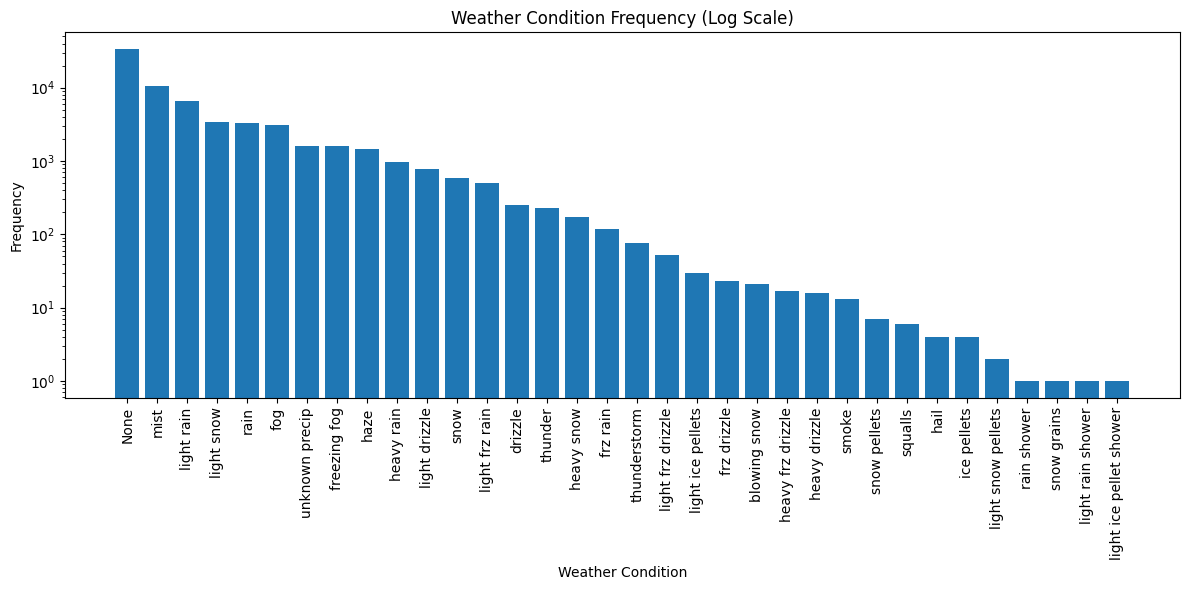

In [18]:
wx_counts = obs['weather_condition'].str.split(',|/').explode().value_counts()
wx_counts = wx_counts.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
plt.bar(wx_counts.index, wx_counts.values)
plt.yscale('log')
plt.xticks(rotation=90)
plt.title('Weather Condition Frequency (Log Scale)')
plt.xlabel('Weather Condition')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [19]:
# RA: Contains "rain" or "drizzle" but not "frz"
obs['RA'] = obs['weather_condition'].str.contains(r'\brain\b|\bdrizzle\b', case=False, na=False) & \
             ~obs['weather_condition'].str.contains(r'\bfrz\b', case=False, na=False)

# SN: Contains "snow", "grains", or "graupel"
obs['SN'] = obs['weather_condition'].str.contains(r'\bsnow\b|\bgrains\b|\bgraupel\b', case=False, na=False)

# ZR: Contains "frz" but not "fog"
obs['ZR'] = obs['weather_condition'].str.contains(r'\bfrz\b', case=False, na=False) & \
             ~obs['weather_condition'].str.contains(r'\bfog\b', case=False, na=False)

# PL: Contains "ice" or "pellets" but not "fog"
obs['PL'] = obs['weather_condition'].str.contains(r'\bice\b|\bpellets\b', case=False, na=False) & \
             ~obs['weather_condition'].str.contains(r'\bfog\b', case=False, na=False)

print(obs)

                          latitude  longitude  elevation state  cwa  \
timestamp           stid                                              
2023-10-31 00:00:00 KAAT  41.48362 -120.56150     4383.0    CA  MFR   
                    KALW  46.09462 -118.28580     1168.0    WA  PDT   
                    KAST  46.15694 -123.88250       10.0    OR  PQR   
                    KAWO  48.15850 -122.15909      125.0    WA  SEW   
                    KBFI  47.54548 -122.31470       20.0    WA  SEW   
...                            ...        ...        ...   ...  ...   
2024-04-29 23:00:00 KMWH  47.19299 -119.31451     1168.0    WA  OTX   
2024-04-29 23:35:00 K1S5  46.32710 -119.97040      768.0    WA  PDT   
                    KELN  47.03377 -120.53132     1745.0    WA  PDT   
2024-04-29 23:53:00 KELN  47.03377 -120.53132     1745.0    WA  PDT   
2024-04-29 23:55:00 KGRF  47.11667 -122.55000      302.0    WA  SEW   

                         observed_air_temp weather_summary weather_condition

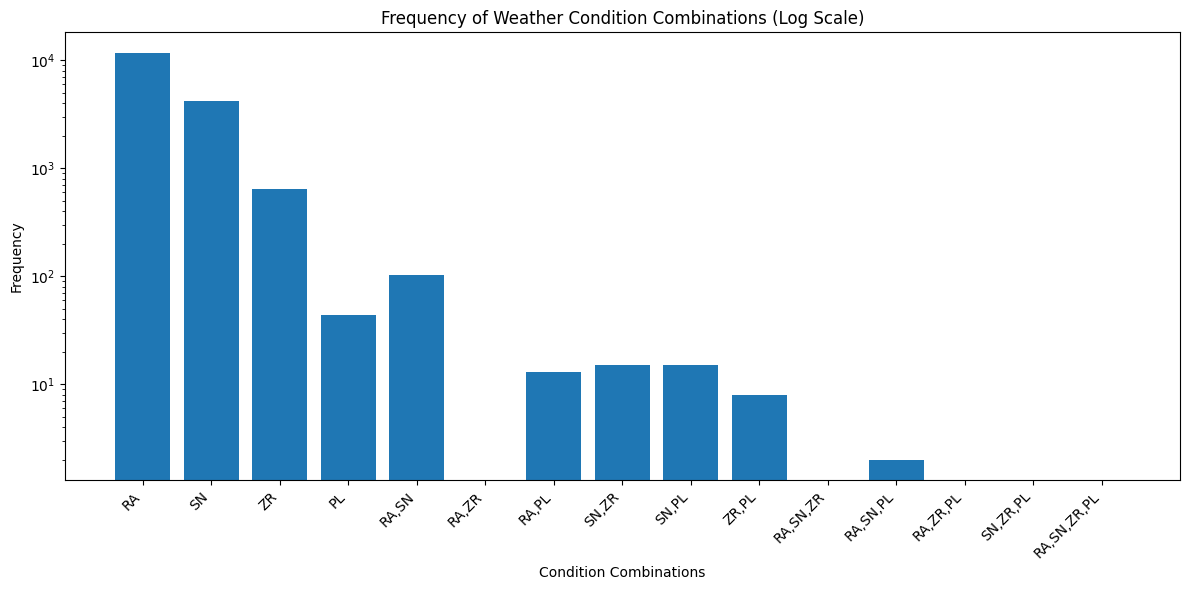

In [20]:
# Create a dictionary to store combination counts
combination_counts = {}

# Iterate through all possible combinations of conditions
for i in range(1, 5):  # Iterate through combinations of 1 to 4 conditions
    for combo in itertools.combinations(['RA', 'SN', 'ZR', 'PL'], i):
        # Create a boolean series indicating if the combination is present
        combo_series = obs[list(combo)].all(axis=1)

        # Count the occurrences of the combination
        combination_counts[','.join(combo)] = combo_series.sum()

# Create a bar plot
plt.figure(figsize=(12, 6))
plt.bar(combination_counts.keys(), combination_counts.values())
plt.xticks(rotation=45, ha='right')
plt.yscale('log')
plt.title('Frequency of Weather Condition Combinations (Log Scale)')
plt.xlabel('Condition Combinations')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

#<hr>----NBM----<hr>

In [21]:
def create_init_times(start_date, end_date):
    """
    Creates a list of datetime objects representing initialization times.

    Args:
        start_date: The start date (inclusive).
        end_date: The end date (inclusive).

    Returns:
        A list of datetime objects.
    """
    init_times = []
    current_date = start_date
    while current_date <= end_date:
        init_times.append(current_date + timedelta(hours=0))  # 00:00
        #init_times.append(current_date + timedelta(hours=12)) # 12:00
        #current_date += timedelta(days=1)
        current_date += timedelta(hours=6)

    return init_times

In [22]:
class NBMGribFetcher:
    def __init__(self, aws_bucket, element, nbm_set, nbm_area, query_vars, save_dir='./nbm_grib2/'):
        self.aws_bucket = aws_bucket
        self.element = element
        self.nbm_set = nbm_set
        self.nbm_area = nbm_area
        self.query_vars = query_vars
        self.save_dir = save_dir
        self.produced_files = []

    def get_nbm_grib_aws(self, aws_request):
        yyyymmdd = datetime.strftime(aws_request['init_time'], '%Y%m%d')
        hh = datetime.strftime(aws_request['init_time'], '%H')

        os.makedirs(self.save_dir, exist_ok=True)

        output_file = (self.save_dir +
                       f"{yyyymmdd}.t{hh}z.fhr{aws_request['fhr']:03d}.{aws_request['element']}.grib2")

        if os.path.isfile(output_file):
            self.produced_files.append(output_file)
            return output_file

        client = boto3.client('s3', config=Config(signature_version=UNSIGNED))

        bucket_dir = f'blend.{yyyymmdd}/{hh}/{self.nbm_set}/'
        grib_file = f'{bucket_dir}blend.t{hh}z.{self.nbm_set}.f{aws_request["fhr"]:03d}.{self.nbm_area}.grib2'
        index_file = f'{grib_file}.idx'

        try:
            print(self.aws_bucket, index_file)

            index_data_raw = client.get_object(
                Bucket=self.aws_bucket, Key=index_file)['Body'].read().decode().split('\n')

        except Exception as e:
            print(f"Error fetching index file: {e}")
            client.close()
            return

        cols = ['num', 'byte', 'date', 'var', 'level', 'forecast', 'fthresh', 'ftype']
        index_data = []
        for item in index_data_raw:
            item_split = item.split(':')
            if len(item_split) >= 8:
                index_data.append(item_split[:8])
            elif len(item_split) == 7:  # Handle cases where columns are missing
                item_split.append('')
                index_data.append(item_split[:8])

        index_data = pd.DataFrame(index_data, columns=cols)

        index_data = index_data[index_data['num'] != '']
        index_data['num'] = index_data['num'].astype(int)
        index_data = index_data.set_index('num')
        index_data.loc[index_data.shape[0] + 1] = [''] * index_data.shape[1]

        index_subset = index_data[index_data['var'].isin(self.query_vars)]
        index_subset = index_subset[~index_subset['fthresh'].str.contains(
            '% level|std dev', na=False)]

        for i in index_subset.index:
            if (int(i) + 1) in index_data.index:
                index_subset.at[i, 'byte'] = (
                    index_data.at[i, 'byte'],
                    index_data.at[int(i) + 1, 'byte'])
            else:
                index_subset.at[i, 'byte'] = (
                    index_data.at[i, 'byte'], '')

        # Fetch only the selected variables
        with open(output_file, 'wb') as wfp:
            for index, item in index_subset.iterrows():
                byte_range = f"bytes={item['byte'][0]}-{item['byte'][1]}"
                output_bytes = client.get_object(
                    Bucket=self.aws_bucket, Key=grib_file, Range=byte_range)
                for chunk in output_bytes['Body'].iter_chunks(chunk_size=4096):
                    wfp.write(chunk)

        client.close()
        self.produced_files.append(output_file)
        return output_file

    def fetch_for_init_times(self, init_times, fhr):
        with ThreadPoolExecutor() as executor:
            futures = [executor.submit(self.get_nbm_grib_aws, {
                'init_time': init_time,
                'fhr': fhr,
                'element': self.element
            }) for init_time in init_times]

            for future in as_completed(futures):
                result = future.result()
                print(f"Downloaded: {result}")

        return self.produced_files

In [23]:
aws_bucket_nbm = 'noaa-nbm-grib2-pds'
element = 'powt'
nbm_set = 'core'
nbm_area = 'co'
query_vars = ['APTMP', 'TMP', 'PTYPE', 'SNOWLVL', 'RH']
nbm_dir = './nbm_grib2/'

# Already defined
# start_date = datetime(2025, 1, 1)
# end_date = datetime(2025, 1, 21)
fhr = int(lead_days_selection) * 24

In [24]:
init_times = create_init_times(start_date, end_date)
# valid_times = [t+timedelta(hours=fhr) for t in init_times]

fetcher = NBMGribFetcher(aws_bucket_nbm, element, nbm_set, nbm_area, query_vars, nbm_dir)
nbm_files = fetcher.fetch_for_init_times(init_times, fhr)

noaa-nbm-grib2-pdsnoaa-nbm-grib2-pds blend.20231101/18/core/blend.t18z.core.f024.co.grib2.idx
noaa-nbm-grib2-pds blend.20231102/06/core/blend.t06z.core.f024.co.grib2.idx
 blend.20231101/06/core/blend.t06z.core.f024.co.grib2.idx
noaa-nbm-grib2-pds blend.20231101/00/core/blend.t00z.core.f024.co.grib2.idx
noaa-nbm-grib2-pds blend.20231102/00/core/blend.t00z.core.f024.co.grib2.idx
noaa-nbm-grib2-pds blend.20231101/12/core/blend.t12z.core.f024.co.grib2.idx
Downloaded: ./nbm_grib2/20231101.t18z.fhr024.powt.grib2
noaa-nbm-grib2-pds blend.20231102/12/core/blend.t12z.core.f024.co.grib2.idx
Downloaded: ./nbm_grib2/20231102.t06z.fhr024.powt.grib2
noaa-nbm-grib2-pds blend.20231102/18/core/blend.t18z.core.f024.co.grib2.idx
Downloaded: ./nbm_grib2/20231101.t12z.fhr024.powt.grib2
noaa-nbm-grib2-pds blend.20231103/00/core/blend.t00z.core.f024.co.grib2.idx
Downloaded: ./nbm_grib2/20231101.t00z.fhr024.powt.grib2
noaa-nbm-grib2-pds blend.20231103/06/core/blend.t06z.core.f024.co.grib2.idx
Downloaded: ./nb

In [25]:
def relabel_grib(file_path):
    grbs = pygrib.open(file_path)
    relabeled = []

    for grb in grbs:
        # Try to use grb.name first
        name = grb.name

        # If grb.name is unknown or doesn't match, fall back to message string
        if name not in variable_lookup:
            try:
                # Extract name from the message string
                message_parts = grb.__str__().split(":")
                if len(message_parts) > 1:
                    name = message_parts[1].strip()  # Use the second part (after the first ':')
                else:
                    name = "Unknown Variable"
            except Exception:
                name = "Unknown Variable"

        # Relabel known variables
        if name in variable_lookup:
            label = variable_lookup[name]
        elif name == "Precipitation type":
            # Handle Precipitation Type using lowerLimit
            try:
                lower_limit = grb.lowerLimit  # Extract lowerLimit metadata
                label = f"Precipitation Type ({ptype_lookup.get(lower_limit, 'Unknown')})"
            except AttributeError:
                label = "Precipitation Type (Unknown)"
        else:
            label = f"Unknown Variable ({name})"

        # Add level information if applicable
        level = grb.level
        level_type = grb.typeOfLevel
        if level_type == "heightAboveGround":
            label += f" ({level} m)"
        elif level_type == "heightAboveSea":
            label += f" ({level} m above sea level)"
        elif level_type == "surface":
            label += " (Surface)"

        relabeled.append(label)

    grbs.close()
    return relabeled

In [26]:
# Target hours to aggregate to
target_hours = pd.to_timedelta([0, 6, 12, 18], unit="h")

# Reset index to work with timestamps
obs_reset = obs.reset_index()

# Save the original timestamp in a new column
obs_reset["ob_timestamp"] = obs_reset["timestamp"]

# Determine the nearest target time for each observation
obs_reset["nearest_target"] = obs_reset["timestamp"].apply(
    lambda ts: ts.floor("D") + min(target_hours, key=lambda h: abs((ts - (ts.floor("D") + h)).total_seconds()))
)

# Calculate the time difference between the observation and the nearest target
obs_reset["time_diff"] = abs(obs_reset["timestamp"] - obs_reset["nearest_target"])

# Filter by the tolerance
obs_filtered = obs_reset[obs_reset["time_diff"] <= tolerance]

# Keep only the nearest observation for each group (stid, nearest_target)
obs_filtered = obs_filtered.loc[obs_filtered.groupby(["stid", "nearest_target"])["time_diff"].idxmin()]

# Relabel timestamp to the hour it is attributed to
obs_filtered["timestamp"] = obs_filtered["nearest_target"]

# Drop unnecessary columns if needed
obs_filtered = obs_filtered.drop(columns=["time_diff", "nearest_target"])

# Reorder columns to make ob_timestamp the first column
columns_order = ["ob_timestamp"] + [col for col in obs_filtered.columns if col != "ob_timestamp"]
obs_filtered = obs_filtered[columns_order]

# Reinstate the multiindex [timestamp, stid]
obs_filtered.set_index(["timestamp", "stid"], inplace=True)
obs_filtered.sort_index(inplace=True)

# Result: filtered dataframe
obs_filtered

ob_timestamp  latitude  longitude  elevation  \
timestamp           stid                                                       
2023-10-31 00:00:00 K0S9 2023-10-31 00:15:00  48.05517 -122.81159      105.0   
                    K1S5 2023-10-31 00:15:00  46.32710 -119.97040      768.0   
                    K3S8 2023-10-31 00:15:00  42.51011 -123.38798     1126.0   
                    K4S1 2023-10-31 00:15:00  42.41536 -124.42492       16.0   
                    K4S2 2023-10-31 00:15:00  45.67457 -121.53493      600.0   
...                                      ...       ...        ...        ...   
2024-04-28 18:00:00 KSKA 2024-04-28 17:55:00  47.61667 -117.65000     2461.0   
                    KTIW 2024-04-28 18:13:00  47.26750 -122.57611      315.0   
2024-04-29 00:00:00 KRLD 2024-04-29 00:15:00  46.30859 -119.30580      387.0   
2024-04-29 06:00:00 KSXT 2024-04-29 05:56:00  42.60000 -123.36560     3842.0   
2024-04-29 12:00:00 K1YT 2024-04-29 11:55:00  46.66670 -120.45000     1437.0   

                         state  cwa observed_air_temp weather_summary  \
timestamp           stid                                                
2023-10-31 00:00:00 K0S9    WA  SEW              50.0           clear   
                    K1S5    WA  PDT              48.2           clear   
                    K3S8    OR  MFR              64.4           clear   
                    K4S1    OR  MFR              57.2            haze   
                    K4S2    OR  PQR              46.4           clear   
...                        ...  ...               ...             ...   
2024-04-28 18:00:00 KSKA    WA  OTX             52.52          broken   
                    KTIW    WA  SEW             46.94            rain   
2024-04-29 00:00:00 KRLD    WA  PDT             65.84       scattered   
2024-04-29 06:00:00 KSXT    OR  MFR             35.06      light rain   
2024-04-29 12:00:00 K1YT    WA  PDT             36.68       scattered   

                         weather_condition weather_cond_code  \
timestamp           stid                                       
2023-10-31 00:00:00 K0S9              None              None   
                    K1S5              None              None   
                    K3S8              None              None   
                    K4S1              haze               6.0   
                    K4S2              None              None   
...                                    ...               ...   
2024-04-28 18:00:00 KSKA              None              None   
                    KTIW              rain               1.0   
2024-04-29 00:00:00 KRLD              None              None   
2024-04-29 06:00:00 KSXT        light rain              13.0   
2024-04-29 12:00:00 K1YT              None              None   

                         past_weather_code weather_cond_code_synop     RA  \
timestamp           stid                                                    
2023-10-31 00:00:00 K0S9              None                    None  False   
                    K1S5              None                    None  False   
                    K3S8              None                    None  False   
                    K4S1              None                    None  False   
                    K4S2              None                    None  False   
...                                    ...                     ...    ...   
2024-04-28 18:00:00 KSKA              None                    None  False   
                    KTIW              None                    None   True   
2024-04-29 00:00:00 KRLD              None                    None  False   
2024-04-29 06:00:00 KSXT              None                    None   True   
2024-04-29 12:00:00 K1YT              None                    None  False   

                             SN     ZR     PL  
timestamp           stid                       
2023-10-31 00:00:00 K0S9  False  False  False  
                    K1S5  False  False  False  
              

In [27]:
# Define mappings for precipitation type (Code Table 4.201)
ptype_lookup = {
    1: "Rain",
    3: "Freezing rain",
    5: "Snow",
    6: "Snow",
    7: "Snow",
    8: "Ice pellets",
}

# Define general variable lookups
variable_lookup = {
    "Apparent temperature": "Apparent Temperature",
    "Temperature": "Surface Temperature",
    "2 metre temperature": "2 Meter Temperature",
    "236": "Snow Level",  # Map 236 to "Snow Level"
    "2 metre relative humidity": "Relative Humidity"
}

# Define column renaming mappings
column_rename_mapping = {
    'Precipitation Type (Snow) (Surface)': 'PSN',
    'Precipitation Type (Rain) (Surface)': 'PRA',
    'Precipitation Type (Ice pellets) (Surface)': 'PPL',
    'Precipitation Type (Freezing rain) (Surface)': 'PZR',
    'Snow Level (0 m above sea level)': 'snowlvl',
    'Surface Temperature (Surface)': 'tsfc',
    '2 Meter Temperature (2 m)': 't2m',
    'Apparent Temperature (2 m)': 'tapp',
    'Relative Humidity (2 m)':'FXRH'
}

def ll_to_index(lat, lon, datalats, datalons):
    """
    Find the nearest grid point index for the given latitude and longitude.
    """
    dist = np.sqrt((datalats - lat)**2 + (datalons - lon)**2)
    return np.unravel_index(np.argmin(dist), datalats.shape)

def extract_nbm_value(index, nbm_data):
    """
    Extract the value from the GRIB data at the specified index (y, x).
    """
    y, x = index
    return nbm_data[y, x]

def relabel_grib_message(grb):
    """
    Relabel a GRIB message to create a human-readable column name.
    """
    # Try to use grb.name first
    name = grb.name

    if name not in variable_lookup:
        try:
            message_parts = grb.__str__().split(":")
            if len(message_parts) > 1:
                name = message_parts[1].strip()
            else:
                name = "Unknown Variable"
        except Exception:
            name = "Unknown Variable"

    if name in variable_lookup:
        label = variable_lookup[name]
    elif name == "Precipitation type":
        try:
            lower_limit = grb.lowerLimit
            label = f"Precipitation Type ({ptype_lookup.get(lower_limit, 'Unknown')})"
        except AttributeError:
            label = "Precipitation Type (Unknown)"
    else:
        label = f"Unknown Variable ({name})"

    level = grb.level
    level_type = grb.typeOfLevel
    if level_type == "heightAboveGround":
        label += f" ({level} m)"
    elif level_type == "heightAboveSea":
        label += f" ({level} m above sea level)"
    elif level_type == "surface":
        label += " (Surface)"

    return label

def process_grib_files(df, grib_files):
    """
    Process GRIB files dynamically to extract relevant grid point values for the DataFrame.
    """
    for grib_file in grib_files:
        if os.path.isfile(grib_file):
            print(f"Processing GRIB file: {grib_file}")
            nbm = pygrib.open(grib_file)

            # If not yet indexed, create grib_index for matching grid points
            if 'grib_index' not in df.columns:
                # print("Creating grib_index for latitude/longitude points.")
                nbmlats, nbmlons = nbm.message(1).latlons()
                # print(f"GRIB file lat/lon grid shape: {nbmlats.shape}")

                df_indexed = df.reset_index()[['stid', 'latitude', 'longitude']].drop_duplicates()

                ll_to_index_mapped = partial(ll_to_index, datalats=nbmlats, datalons=nbmlons)

                df_indexed['grib_index'] = df_indexed.swifter.apply(
                    lambda x: ll_to_index_mapped(x.latitude, x.longitude), axis=1
                )
                # print("grib_index creation complete.")

                # Extract the grid lat/lon for validation
                extract_nbm_lats_mapped = partial(extract_nbm_value, nbm_data=nbmlats)
                extract_nbm_lons_mapped = partial(extract_nbm_value, nbm_data=nbmlons)

                df_indexed['grib_lat'] = df_indexed['grib_index'].apply(extract_nbm_lats_mapped)
                df_indexed['grib_lon'] = df_indexed['grib_index'].apply(extract_nbm_lons_mapped)

                df_indexed.set_index('stid', inplace=True)

                df = df.reset_index().join(
                    df_indexed[['grib_index', 'grib_lat', 'grib_lon']], on='stid'
                ).set_index(['timestamp', 'stid']).sort_index()
                # print("Updated DataFrame with grib_index, grib_lat, and grib_lon.")

            # Process GRIB messages dynamically
            for idx, msg in enumerate(nbm):
                # print(f"Processing message {idx + 1}: {msg.shortName}, validDate: {msg.validDate}")
                name = relabel_grib_message(msg)
                # print(f"Relabeled message to column: {name}")

                if name not in df.columns:
                    df[name] = np.nan
                    # print(f"Added new column: {name}")

                extract_nbm_value_mapped = partial(extract_nbm_value, nbm_data=msg.values)

                valid_date = msg.validDate
                if valid_date in df.index.get_level_values('timestamp'):
                    df.loc[valid_date, name] = df.loc[valid_date]['grib_index'].apply(
                        extract_nbm_value_mapped
                    ).values
                    # print(f"Filled data for column: {name}, validDate: {valid_date}")

            nbm.close()
        else:
            print(f"GRIB file not found: {grib_file}")

    return df

def convert_kelvin_to_fahrenheit(df, columns):
    """
    Convert the specified columns from Kelvin to Fahrenheit.
    """
    for column in columns:
        if column in df.columns:
            print(f"Converting column {column} from Kelvin to Fahrenheit.")
            df[column] = (df[column] - 273.15) * 9 / 5 + 32
    return df

In [28]:
# Process GRIB files
processed_df = process_grib_files(obs_filtered, nbm_files)

# Rename columns based on the mapping
processed_df.rename(columns=column_rename_mapping, inplace=True)

# Convert specified columns from Kelvin to Fahrenheit
columns_to_convert = ['t2m', 'tsfc', 'tapp']
processed_df = convert_kelvin_to_fahrenheit(processed_df, columns_to_convert)

processed_df.rename(columns={'observed_air_temp':'T', 't2m':'FXT'}, inplace=True)
processed_df['snowlvl'] = processed_df['snowlvl'] * 3.28084 # m to ft

# Print the updated DataFrame
processed_df

Processing GRIB file: ./nbm_grib2/20231101.t18z.fhr024.powt.grib2


Pandas Apply:   0%|          | 0/89 [00:00<?, ?it/s]

Processing GRIB file: ./nbm_grib2/20231102.t06z.fhr024.powt.grib2
Processing GRIB file: ./nbm_grib2/20231101.t12z.fhr024.powt.grib2
Processing GRIB file: ./nbm_grib2/20231101.t00z.fhr024.powt.grib2
Processing GRIB file: ./nbm_grib2/20231102.t00z.fhr024.powt.grib2
Processing GRIB file: ./nbm_grib2/20231101.t06z.fhr024.powt.grib2
Processing GRIB file: ./nbm_grib2/20231102.t12z.fhr024.powt.grib2
Processing GRIB file: ./nbm_grib2/20231103.t00z.fhr024.powt.grib2
Processing GRIB file: ./nbm_grib2/20231102.t18z.fhr024.powt.grib2
Processing GRIB file: ./nbm_grib2/20231103.t12z.fhr024.powt.grib2
Processing GRIB file: ./nbm_grib2/20231103.t18z.fhr024.powt.grib2
Processing GRIB file: ./nbm_grib2/20231103.t06z.fhr024.powt.grib2
Processing GRIB file: ./nbm_grib2/20231104.t00z.fhr024.powt.grib2
Processing GRIB file: ./nbm_grib2/20231104.t06z.fhr024.powt.grib2
Processing GRIB file: ./nbm_grib2/20231104.t12z.fhr024.powt.grib2
Processing GRIB file: ./nbm_grib2/20231105.t00z.fhr024.powt.grib2
Processing

ob_timestamp  latitude  longitude  elevation  \
timestamp           stid                                                       
2023-10-31 00:00:00 K0S9 2023-10-31 00:15:00  48.05517 -122.81159      105.0   
                    K1S5 2023-10-31 00:15:00  46.32710 -119.97040      768.0   
                    K3S8 2023-10-31 00:15:00  42.51011 -123.38798     1126.0   
                    K4S1 2023-10-31 00:15:00  42.41536 -124.42492       16.0   
                    K4S2 2023-10-31 00:15:00  45.67457 -121.53493      600.0   
...                                      ...       ...        ...        ...   
2024-04-28 18:00:00 KSKA 2024-04-28 17:55:00  47.61667 -117.65000     2461.0   
                    KTIW 2024-04-28 18:13:00  47.26750 -122.57611      315.0   
2024-04-29 00:00:00 KRLD 2024-04-29 00:15:00  46.30859 -119.30580      387.0   
2024-04-29 06:00:00 KSXT 2024-04-29 05:56:00  42.60000 -123.36560     3842.0   
2024-04-29 12:00:00 K1YT 2024-04-29 11:55:00  46.66670 -120.45000     1437.0   

                         state  cwa      T weather_summary weather_condition  \
timestamp           stid                                                       
2023-10-31 00:00:00 K0S9    WA  SEW   50.0           clear              None   
                    K1S5    WA  PDT   48.2           clear              None   
                    K3S8    OR  MFR   64.4           clear              None   
                    K4S1    OR  MFR   57.2            haze              haze   
                    K4S2    OR  PQR   46.4           clear              None   
...                        ...  ...    ...             ...               ...   
2024-04-28 18:00:00 KSKA    WA  OTX  52.52          broken              None   
                    KTIW    WA  SEW  46.94            rain              rain   
2024-04-29 00:00:00 KRLD    WA  PDT  65.84       scattered              None   
2024-04-29 06:00:00 KSXT    OR  MFR  35.06      light rain        light rain   
2024-04-29 12:00:00 K1YT    WA  PDT  36.68       scattered              None   

                         weather_cond_code  ...    grib_lon  PZR   PRA  PPL  \
timestamp           stid                    ...                               
2023-10-31 00:00:00 K0S9              None  ... -122.805141  NaN   NaN  NaN   
                    K1S5              None  ... -119.972130  NaN   NaN  NaN   
                    K3S8              None  ... -123.382098  NaN   NaN  NaN   
                    K4S1               6.0  ... -124.437229  NaN   NaN  NaN   
                    K4S2              None  ... -121.530929  NaN   NaN  NaN   
...                                    ...  ...         ...  ...   ...  ...   
2024-04-28 18:00:00 KSKA              None  ... -117.642062  0.0  13.1  0.0   
                    KTIW               1.0  ... -122.565479  0.0  66.1  0.0   
2024-04-29 00:00:00 KRLD              None  ... -119.311345  0.0   0.0  0.0   
2024-04-29 06:00:00 KSXT              13.0  ... -123.377765  0.0  31.0  0.0   
2024-04-29 12:00:00 K1YT              None  ... -120.442204  0.0   8.2  0.0   

                           PSN  FXRH     snowlvl    tsfc        FXT       tapp  
timestamp           stid                                                        
2023-10-31 00:00:00 K0S9   NaN   NaN         NaN     NaN        NaN        NaN  
                    K1S5   NaN   NaN         NaN     NaN        NaN        NaN  
                    K3S8   NaN   NaN         NaN     NaN        NaN        NaN  
                    K4S1   NaN   NaN         NaN     NaN        NaN        NaN  
                    K4S2   NaN   NaN         NaN     NaN        NaN        NaN  
...                        ...   ...         ...     ...        ...        ...  
2024-04-28 18:00:00 KSKA   0.0  61.0  4593.17600 -459.67  50.017974  50.360000  
                    KTIW   0.0  78.0  3254.59328 -459.67  49.297974  44.600000  
2024-04-29 00:00:00 KRLD   0.0  30.0  4514.43584 -459.67  64.616035  64.580000  
2024-04-29 06:00:00 KSXT   0.0 

In [29]:
subset = processed_df[['T', 'FXT', 'FXRH', 'elevation', 'snowlvl', 'RA', 'SN', 'ZR', 'PL', 'PRA', 'PZR', 'PSN', 'PPL']]
subset.dropna()

T        FXT  FXRH  elevation      snowlvl  \
timestamp           stid                                                   
2023-11-02 00:00:00 K1S5  45.68  45.355991  64.0      768.0   9028.87168   
                    K4S2   42.8  46.075991  82.0      600.0  10078.74048   
                    KAST   53.6  53.995991  84.0       10.0  10052.49376   
                    KBFI   51.8  51.835991  72.0       20.0   9081.36512   
                    KGCD  53.06  54.715991  41.0     3675.0   9632.54624   
...                         ...        ...   ...        ...          ...   
2024-04-28 18:00:00 KSKA  52.52  50.017974  61.0     2461.0   4593.17600   
                    KTIW  46.94  49.297974  78.0      315.0   3254.59328   
2024-04-29 00:00:00 KRLD  65.84  64.616035  30.0      387.0   4514.43584   
2024-04-29 06:00:00 KSXT  35.06  38.227974  80.0     3842.0   3727.03424   
2024-04-29 12:00:00 K1YT  36.68  38.461982  72.0     1437.0   2414.69824   

                             RA     SN     ZR     PL   PRA  PZR   PSN  PPL  
timestamp           stid                                                    
2023-11-02 00:00:00 K1S5  False  False  False  False  45.1  0.0   0.0  0.0  
                    K4S2   True  False  False  False  83.1  0.0   0.0  0.0  
                    KAST   True  False  False  False  99.0  0.0   0.0  0.0  
                    KBFI   True  False  False  False  61.9  0.0   0.0  0.0  
                    KGCD   True  False  False  False  32.6  0.0   0.0  0.0  
...                         ...    ...    ...    ...   ...  ...   ...  ...  
2024-04-28 18:00:00 KSKA  False  False  False  False  13.1  0.0   0.0  0.0  
                    KTIW   True  False  False  False  66.1  0.0   0.0  0.0  
2024-04-29 00:00:00 KRLD  False  False  False  False   0.0  0.0   0.0  0.0  
2024-04-29 06:00:00 KSXT   True  False  False  False  31.0  0.0   0.0  0.0  
2024-04-29 12:00:00 K1YT  False  False  False  False   8.2  0.0  13.0  0.0  

[5019 rows x 13 columns]

In [30]:
def calculate_wet_bulb_temperature(T, RH):
    """
    Calculate the wet bulb temperature using the empirical formula.
    T: Temperature in Celsius
    RH: Relative Humidity in percentage (0-100)
    Returns: Wet bulb temperature in Celsius
    """
    T_w = (
        T * np.arctan(0.151977 * np.sqrt(RH + 8.313659)) +
        np.arctan(T + RH) -
        np.arctan(RH - 1.676331) +
        0.00391838 * (RH ** (3/2)) * np.arctan(0.023101 * RH) -
        4.686035
    )
    return T_w

# Apply the function to the dataframe
subset['FXTw'] = subset.apply(lambda row: calculate_wet_bulb_temperature(row['FXT'], row['FXRH']), axis=1)
subset.dropna()

T        FXT  FXRH  elevation      snowlvl  \
timestamp           stid                                                   
2023-11-02 00:00:00 K1S5  45.68  45.355991  64.0      768.0   9028.87168   
                    K4S2   42.8  46.075991  82.0      600.0  10078.74048   
                    KAST   53.6  53.995991  84.0       10.0  10052.49376   
                    KBFI   51.8  51.835991  72.0       20.0   9081.36512   
                    KGCD  53.06  54.715991  41.0     3675.0   9632.54624   
...                         ...        ...   ...        ...          ...   
2024-04-28 18:00:00 KSKA  52.52  50.017974  61.0     2461.0   4593.17600   
                    KTIW  46.94  49.297974  78.0      315.0   3254.59328   
2024-04-29 00:00:00 KRLD  65.84  64.616035  30.0      387.0   4514.43584   
2024-04-29 06:00:00 KSXT  35.06  38.227974  80.0     3842.0   3727.03424   
2024-04-29 12:00:00 K1YT  36.68  38.461982  72.0     1437.0   2414.69824   

                             RA     SN     ZR     PL   PRA  PZR   PSN  PPL  \
timestamp           stid                                                     
2023-11-02 00:00:00 K1S5  False  False  False  False  45.1  0.0   0.0  0.0   
                    K4S2   True  False  False  False  83.1  0.0   0.0  0.0   
                    KAST   True  False  False  False  99.0  0.0   0.0  0.0   
                    KBFI   True  False  False  False  61.9  0.0   0.0  0.0   
                    KGCD   True  False  False  False  32.6  0.0   0.0  0.0   
...                         ...    ...    ...    ...   ...  ...   ...  ...   
2024-04-28 18:00:00 KSKA  False  False  False  False  13.1  0.0   0.0  0.0   
                    KTIW   True  False  False  False  66.1  0.0   0.0  0.0   
2024-04-29 00:00:00 KRLD  False  False  False  False   0.0  0.0   0.0  0.0   
2024-04-29 06:00:00 KSXT   True  False  False  False  31.0  0.0   0.0  0.0   
2024-04-29 12:00:00 K1YT  False  False  False  False   8.2  0.0  13.0  0.0   

                               FXTw  
timestamp           stid             
2023-11-02 00:00:00 K1S5  38.655362  
                    K4S2  42.948328  
                    KAST  51.015220  
                    KBFI  46.379247  
                    KGCD  40.861841  
...                             ...  
2024-04-28 18:00:00 KSKA  42.217014  
                    KTIW  45.249474  
2024-04-29 00:00:00 KRLD  44.504671  
2024-04-29 06:00:00 KSXT  35.028777  
2024-04-29 12:00:00 K1YT  33.840539  

[5019 rows x 14 columns]

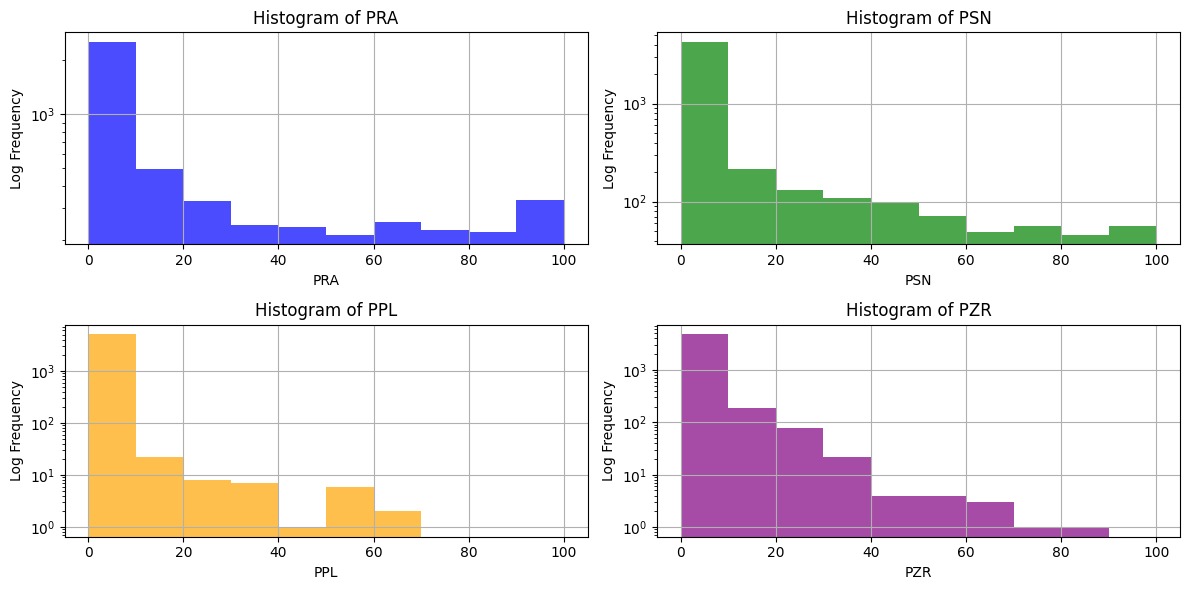

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming `subset` is your DataFrame
# Drop NaN values from the relevant columns before plotting
subset = subset.dropna(subset=['PRA', 'PSN', 'PPL', 'PZR'])

# Create bins from 0 to 100 with a step of 10
bins = np.arange(0, 101, 10)

# Create a figure for the histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Plot histogram for PRA
axes[0, 0].hist(subset['PRA'], bins=bins, color='blue', alpha=0.7, log=True)
axes[0, 0].set_title('Histogram of PRA')
axes[0, 0].set_xlabel('PRA')
axes[0, 0].set_ylabel('Log Frequency')
axes[0, 0].grid(True)

# Plot histogram for PSN
axes[0, 1].hist(subset['PSN'], bins=bins, color='green', alpha=0.7, log=True)
axes[0, 1].set_title('Histogram of PSN')
axes[0, 1].set_xlabel('PSN')
axes[0, 1].set_ylabel('Log Frequency')
axes[0, 1].grid(True)

# Plot histogram for PPL
axes[1, 0].hist(subset['PPL'], bins=bins, color='orange', alpha=0.7, log=True)
axes[1, 0].set_title('Histogram of PPL')
axes[1, 0].set_xlabel('PPL')
axes[1, 0].set_ylabel('Log Frequency')
axes[1, 0].grid(True)

# Plot histogram for PZR
axes[1, 1].hist(subset['PZR'], bins=bins, color='purple', alpha=0.7, log=True)
axes[1, 1].set_title('Histogram of PZR')
axes[1, 1].set_xlabel('PZR')
axes[1, 1].set_ylabel('Log Frequency')
axes[1, 1].grid(True)

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()

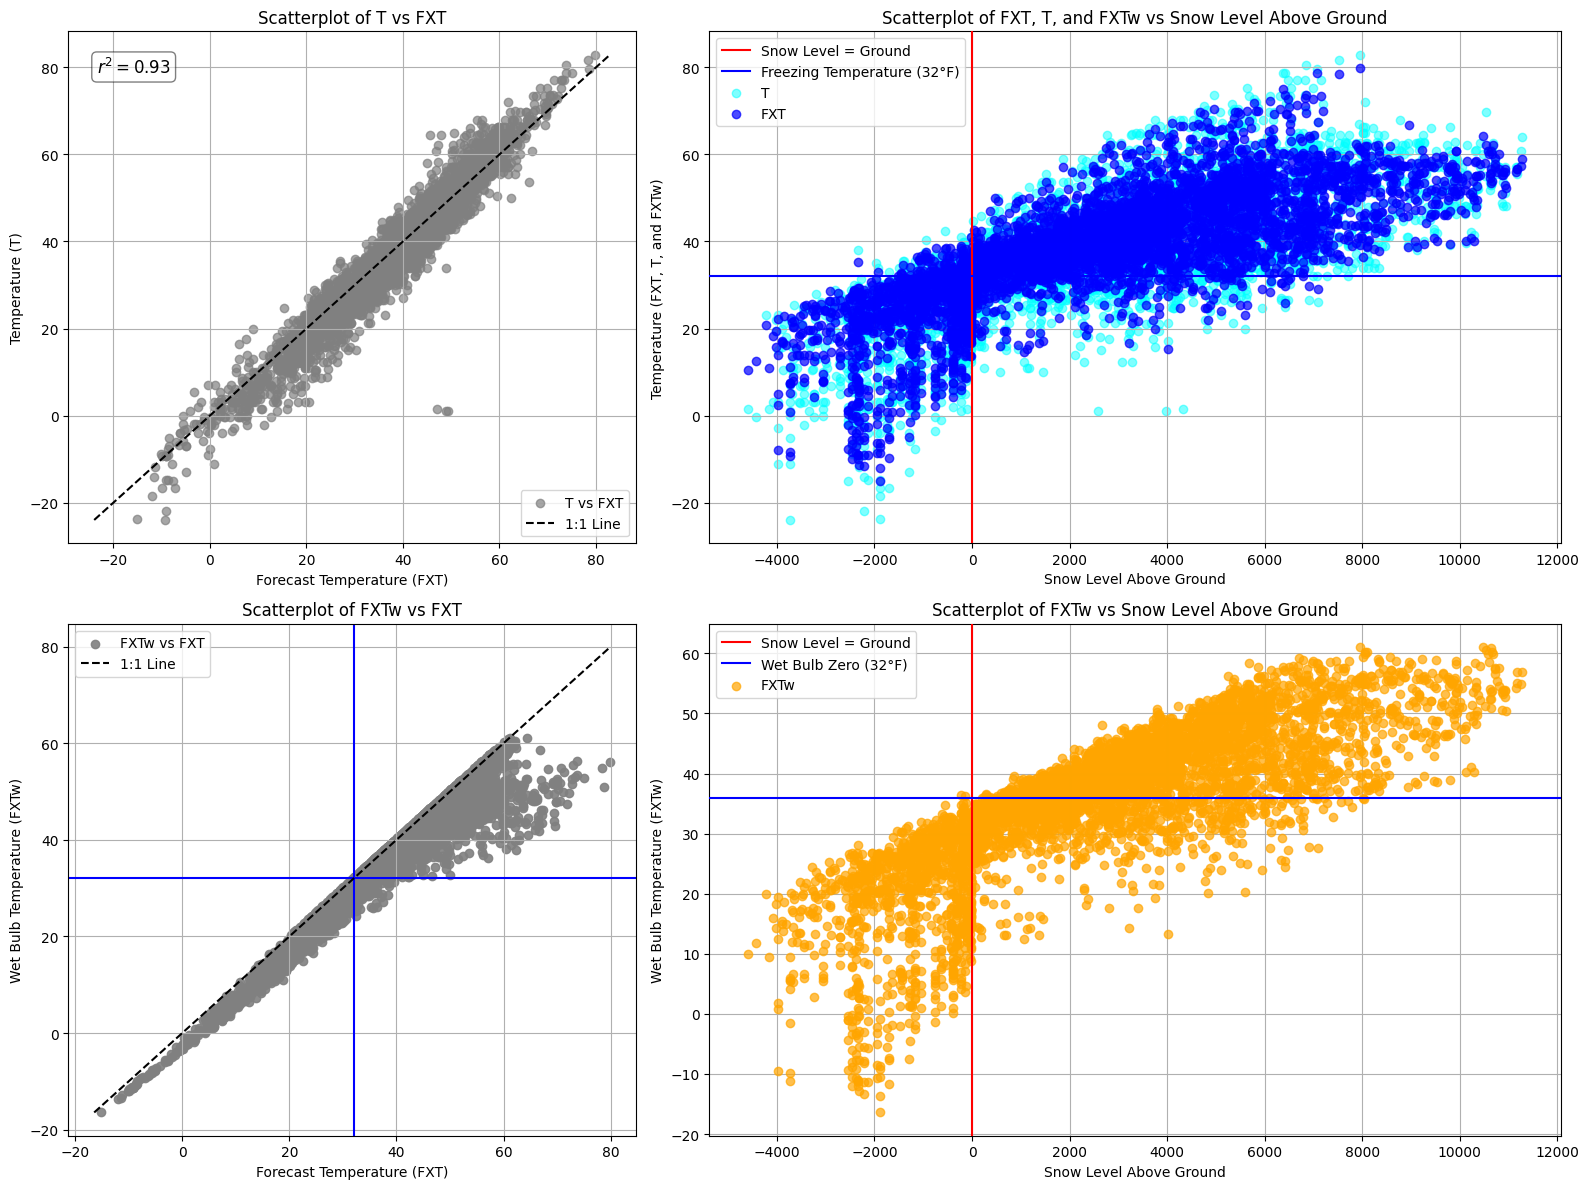

In [32]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import r2_score

# Assuming `subset` is your DataFrame
# Drop NaN values from the relevant columns before calculating and plotting
subset = subset.dropna(subset=['snowlvl', 'elevation', 'FXT', 'T', 'FXTw'])

# Calculate the Snow Level Above Ground
subset['Snow Level Above Ground'] = subset['snowlvl'] - subset['elevation']

# Calculate r^2 value for FXT vs T
r_squared = r2_score(subset['T'], subset['FXT'])

# Create a figure with four subplots in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(16, 12), gridspec_kw={'width_ratios': [1, 1.5]})

# Top Left plot: FXT (x) vs T (y)
axes[0, 0].scatter(
    subset['FXT'],
    subset['T'],
    color='gray',
    alpha=0.7,
    label='T vs FXT'
)
min_val = min(subset['FXT'].min(), subset['T'].min())
max_val = max(subset['FXT'].max(), subset['T'].max())
axes[0, 0].plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--', label='1:1 Line')
axes[0, 0].text(
    0.05, 0.95,
    f'$r^2 = {r_squared:.2f}$',
    transform=axes[0, 0].transAxes,
    fontsize=12,
    verticalalignment='top',
    horizontalalignment='left',
    bbox=dict(boxstyle="round", facecolor="white", alpha=0.5)
)
axes[0, 0].set_xlabel('Forecast Temperature (FXT)')
axes[0, 0].set_ylabel('Temperature (T)')
axes[0, 0].set_title('Scatterplot of T vs FXT')
axes[0, 0].grid(True)
axes[0, 0].legend()

# Top Right plot: Snow Level Above Ground (x) vs FXT, T, and FXTw (y)
axes[0, 1].axvline(0, color='red', label='Snow Level = Ground', zorder=10)
axes[0, 1].axhline(32, color='blue', label='Freezing Temperature (32°F)', zorder=10)

axes[0, 1].scatter(
    subset['Snow Level Above Ground'],
    subset['T'],
    color='cyan',
    alpha=0.5,
    label='T',
    zorder=1
)
axes[0, 1].scatter(
    subset['Snow Level Above Ground'],
    subset['FXT'],
    color='blue',
    alpha=0.7,
    label='FXT',
    zorder=2
)
axes[0, 1].set_xlabel('Snow Level Above Ground')
axes[0, 1].set_ylabel('Temperature (FXT, T, and FXTw)')
axes[0, 1].set_title('Scatterplot of FXT, T, and FXTw vs Snow Level Above Ground')
axes[0, 1].grid(True)
axes[0, 1].legend()

# Bottom Left plot: FXT (x) vs FXTw (y)
axes[1, 0].scatter(
    subset['FXT'],
    subset['FXTw'],
    color='gray',
    alpha=0.9,
    label='FXTw vs FXT'
)
min_val_fxt = min(subset['FXT'].min(), subset['FXTw'].min())
max_val_fxt = max(subset['FXT'].max(), subset['FXTw'].max())
axes[1, 0].axhline(32, color='blue')
axes[1, 0].axvline(32, color='blue')

axes[1, 0].plot([min_val_fxt, max_val_fxt], [min_val_fxt, max_val_fxt], color='black', linestyle='--', label='1:1 Line')
axes[1, 0].set_xlabel('Forecast Temperature (FXT)')
axes[1, 0].set_ylabel('Wet Bulb Temperature (FXTw)')
axes[1, 0].set_title('Scatterplot of FXTw vs FXT')
axes[1, 0].grid(True)
axes[1, 0].legend()

# Bottom Right plot: Snow Level Above Ground (x) vs FXTw (y)
axes[1, 1].axvline(0, color='red', label='Snow Level = Ground', zorder=10)
axes[1, 1].axhline(36, color='blue', label='Wet Bulb Zero (32°F)', zorder=10)
axes[1, 1].scatter(
    subset['Snow Level Above Ground'],
    subset['FXTw'],
    color='orange',
    alpha=0.7,
    label='FXTw',
    zorder=3
)
axes[1, 1].set_xlabel('Snow Level Above Ground')
axes[1, 1].set_ylabel('Wet Bulb Temperature (FXTw)')
axes[1, 1].set_title('Scatterplot of FXTw vs Snow Level Above Ground')
axes[1, 1].grid(True)
axes[1, 1].legend()

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

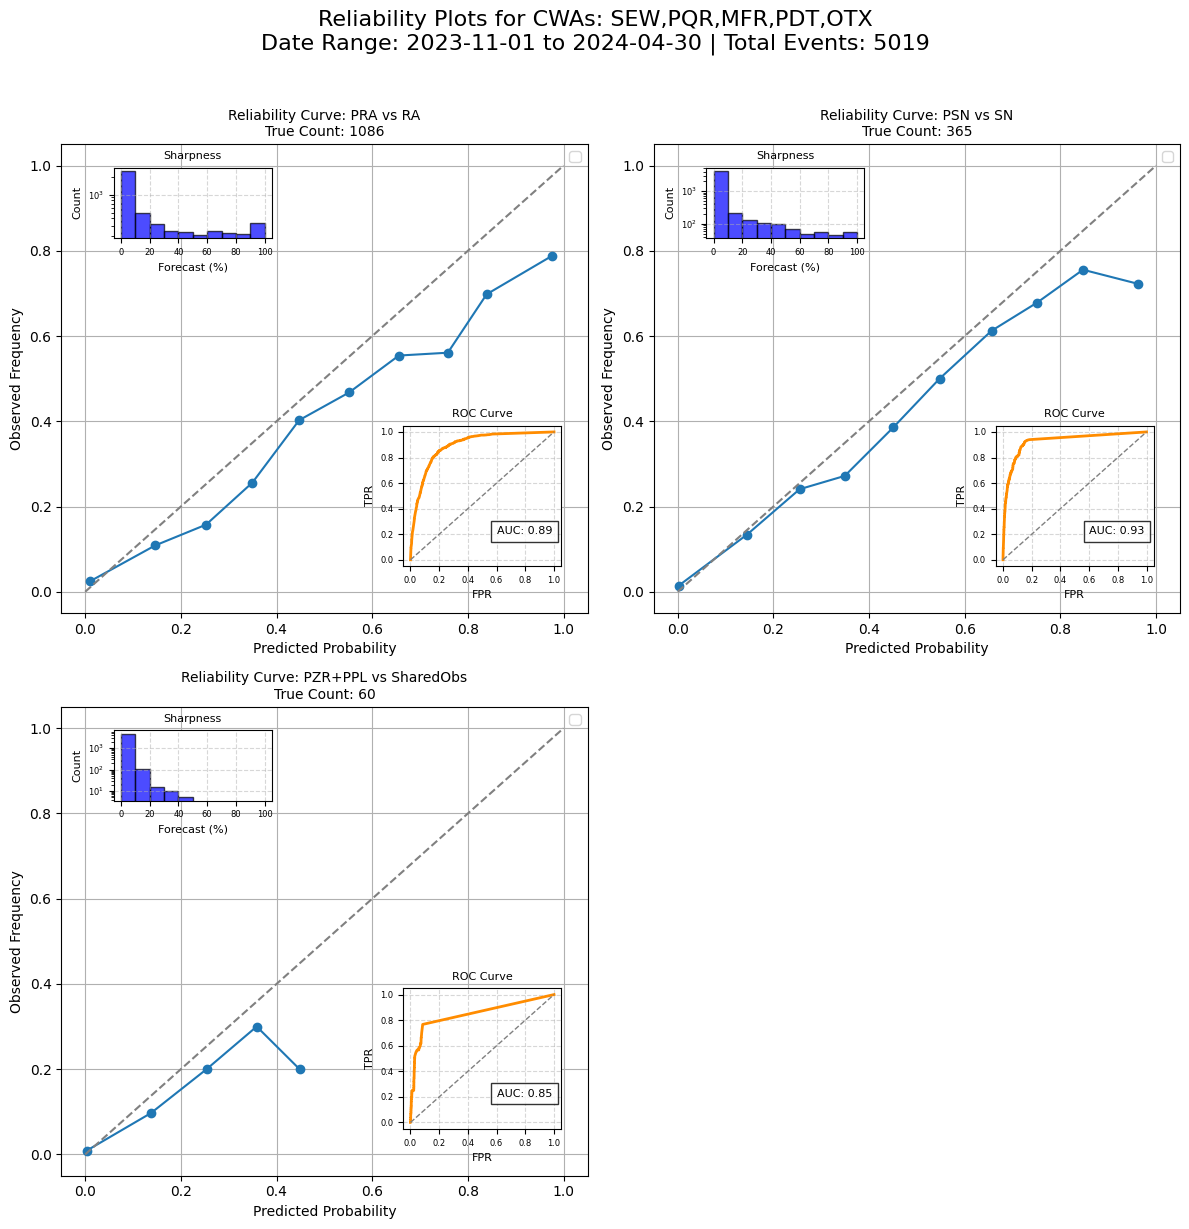

In [93]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.calibration import calibration_curve
from sklearn.metrics import roc_curve, roc_auc_score

# Define the probability/boolean verification pairs
pairs = [
    ('PRA', 'RA'),
    ('PSN', 'SN'),
    ('PZR+PPL', 'SharedObs')  # New combined category for lower-left plot
]

# Create combined category (shared probabilities and observations)
subset['PZR+PPL'] = (subset['PZR'] + subset['PPL']) / 2  # Average of PZR and PPL
subset['SharedObs'] = subset['ZR'] | subset['PL']       # Logical OR of ZR and PL

# Scale probabilities to [0, 1] if they are percentages
for prob_col, _ in pairs:
    if subset[prob_col].max() > 1:  # Check if scaling is needed
        subset[prob_col] = subset[prob_col] / 100

# Create a figure for the 4-panel plot
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Loop through the pairs and generate reliability plots with sharpness diagrams and ROC curves
for idx, (prob_col, obs_col) in enumerate(pairs):
    # Extract probabilities and observed booleans
    probabilities = subset[prob_col]
    observations = subset[obs_col]

    # Compute the calibration curve
    prob_true, prob_pred = calibration_curve(observations, probabilities, n_bins=10, strategy='uniform')

    # Determine the subplot location
    ax = axes[idx // 2, idx % 2]

    # Plot the reliability curve
    ax.plot(prob_pred, prob_true, marker='o', label=None)#'Reliability')
    ax.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Removed label for perfect reliability

    # Count the number of true events for the observed variable
    true_count = observations.sum()

    # Add title with the true count as the second row
    ax.set_title(f'Reliability Curve: {prob_col} vs {obs_col}\nTrue Count: {true_count}', fontsize=10)
    ax.set_xlabel('Predicted Probability')
    ax.set_ylabel('Observed Frequency')
    ax.legend()
    ax.grid(True)

    # Add sharpness diagram (histogram) as an inset in the top-left
    sharpness_ax = ax.inset_axes([0.1, 0.8, 0.3, 0.15])  # [x, y, width, height] in relative coordinates
    sharpness_ax.hist(probabilities * 100, bins=np.arange(0, 110, 10), color='blue', alpha=0.7, edgecolor='black')
    sharpness_ax.set_title('Sharpness', fontsize=8)
    sharpness_ax.set_xlabel('Forecast (%)', fontsize=8)
    sharpness_ax.set_ylabel('Count', fontsize=8)
    sharpness_ax.tick_params(axis='both', which='major', labelsize=6)
    sharpness_ax.grid(True, linestyle='--', alpha=0.5)
    sharpness_ax.set_yscale('log')  # Logarithmic scale for y-axis

    # Add ROC curve as an inset in the bottom-right
    roc_ax = ax.inset_axes([0.65, 0.10, 0.3, 0.3])  # [x, y, width, height] in relative coordinates
    fpr, tpr, _ = roc_curve(observations, probabilities)
    auc_score = roc_auc_score(observations, probabilities)
    roc_ax.plot(fpr, tpr, color='darkorange', lw=2, label='ROC')
    roc_ax.plot([0, 1], [0, 1], linestyle='--', color='gray', lw=1)  # Diagonal line
    roc_ax.set_title('ROC Curve', fontsize=8)
    roc_ax.set_xlabel('FPR', fontsize=8)  # False Positive Rate
    roc_ax.set_ylabel('TPR', fontsize=8)  # True Positive Rate
    roc_ax.tick_params(axis='both', which='major', labelsize=6)
    roc_ax.grid(True, linestyle='--', alpha=0.5)
    # Add AUC score to the ROC inset
    roc_ax.text(0.6, 0.2, f'AUC: {auc_score:.2f}', fontsize=8, bbox=dict(facecolor='white', alpha=0.8))

# Hide the bottom-right plot (left as whitespace)
axes[1, 1].axis('off')  # Turn off the bottom-right plot

# Generate the title
title = (
    f"Reliability Plots for CWAs: {cwa_selection}\n"
    f"Date Range: {start_date} to {end_date} | Total Events: {len(subset)}"
)

# Add the title to the plot
fig.suptitle(title, fontsize=16, y=1.02)  # Set title above the plots

# Adjust layout to avoid overlap
plt.tight_layout()

# Show the plot
plt.show()